# Define Coordinate Reference System (CRS) and Reprojection

Accurate geospatial analysis, particularly when calculating spatial attributes such as area, perimeter, lengths, and slopes for hydrological modeling, fundamentally depends on the selection and application of an appropriate Coordinate Reference System (CRS) or map projection. For the defined study region within the **Ohio Region**, it is essential to choose a projection that minimizes spatial distortions relevant to the scale of analysis (watersheds and sub-basins).

For spatial data referencing within the United States, the **NAD83 datum** is widely adopted and will be utilized as the geodetic datum for this study. Regarding the map projection, Universal Transverse Mercator (UTM) projections are well-suited for regional-scale analyses as they divide the Earth into zones designed to minimize distortion within each zone. The Ohio Region spans primarily **UTM Zone 16N (EPSG:26916)** in the western part and **UTM Zone 17N (EPSG:26917)** in the eastern part. The specific UTM zone chosen for analysis, or the strategy for handling data that spans both zones, will depend on the precise geographic extent of the selected study watersheds within the Ohio Region. Utilizing an appropriate UTM zone minimizes distortions in distance and area measurements across the study area.

The use of a projected coordinate system like UTM, with meters as the unit of measurement, simplifies the calculation and interpretation of spatial attributes critical for deriving geomorphological parameters used in hydrological modeling. This approach ensures consistency and accuracy in downstream analyses, such as calculating drainage density (km/km²) or basin lengths (meters or kilometers).

For analyses covering vast areas or requiring equal-area properties across continents, projections like Albers Equal Area or Lambert Conformal Conic might be considered. However, for this focused study on watersheds and sub-basins within the Ohio Region, employing the relevant UTM zone(s) provides the most practical framework for accurate spatial attribute derivation at the required scale.

In [47]:
# Import modules
import geopandas as gpd
from matplotlib import pyplot as plt
from plotnine import *
from pathlib import Path
import json
import warnings


In [51]:
warnings.filterwarnings("ignore")

In [37]:
# Load style configuration for maps
project_root_path = Path.cwd().parent.parent
map_style_path = project_root_path / 'config' / 'map_style.json'
with open(map_style_path, 'r') as f:
    map_style = json.load(f).get('map_styles',[])

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tnmid       1 non-null      object        
 1   metasource  1 non-null      object        
 2   sourcedata  0 non-null      object        
 3   sourceorig  1 non-null      object        
 4   sourcefeat  0 non-null      object        
 5   loaddate    1 non-null      datetime64[ms]
 6   referenceg  0 non-null      object        
 7   areaacres   1 non-null      float64       
 8   areasqkm    1 non-null      float64       
 9   states      1 non-null      object        
 10  huc2        1 non-null      object        
 11  name        1 non-null      object        
 12  shape_Leng  0 non-null      float64       
 13  shape_Area  0 non-null      float64       
 14  ObjectID    1 non-null      int32         
 15  geometry    1 non-null      geometry      
dtypes: datetime64[ms](1), 

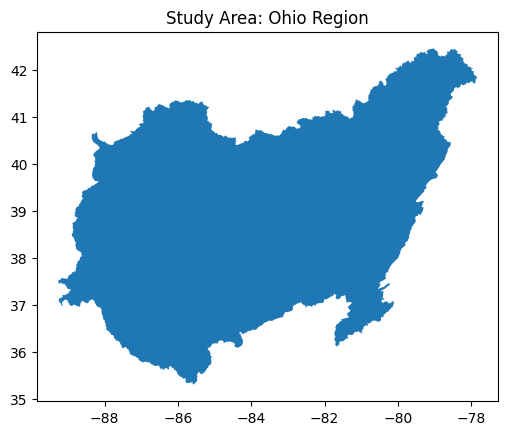

In [40]:
# Load the study area shapefile
study_area_path = r'/Users/alan/Data Science Projects/ML-ModClark-IUH-Model/data/silver/geo/gpkg/study_area.gpkg'
study_area = gpd.read_file(study_area_path)
study_area.info()
study_area.plot()
plt.title('Study Area: Ohio Region')
plt.show()

In [21]:
# Load the World UTM Grid geojson
world_utm_grid_path = r'/Users/alan/Data Science Projects/ML-ModClark-IUH-Model/data/bronze/geo/json/World_UTM_Grid.geojson'
world_utm_grid = gpd.read_file(world_utm_grid_path)
world_utm_grid.head()

,FID,ZONE,ROW_,WEST_VALUE,CM_VALUE,EAST_VALUE,geometry
0,1,0,Y,NoZN,NoZN,NoZN,"POLYGON ((8.38191e-8 89, 8.3819e-8 88, 8.3819e..."
1,2,22,P,54W,51W,48W,"POLYGON ((-54 16, -53 16, -52 16, -51 16, -50 ..."
2,3,0,Z,NoZN,NoZN,NoZN,"POLYGON ((179.99999 84, 179 84, 178 84, 177 84..."
3,4,1,X,180W,177W,174W,"POLYGON ((-179.99999 84, -179 84, -178 84, -17..."
4,5,2,X,174W,171W,168W,"POLYGON ((-174 84, -173 84, -172 84, -171 84, ..."


In [42]:
# Check Coordinate Reference System (CRS)
print(f"Study Area CRS: {study_area.crs}")
print(f"World UTM Grid CRS: {world_utm_grid.crs}")

Study Area CRS: EPSG:4269
World UTM Grid CRS: EPSG:4326


In [43]:
# Reproject the study area to match the UTM grid CRS
study_area_reprojected = study_area.to_crs(world_utm_grid.crs)

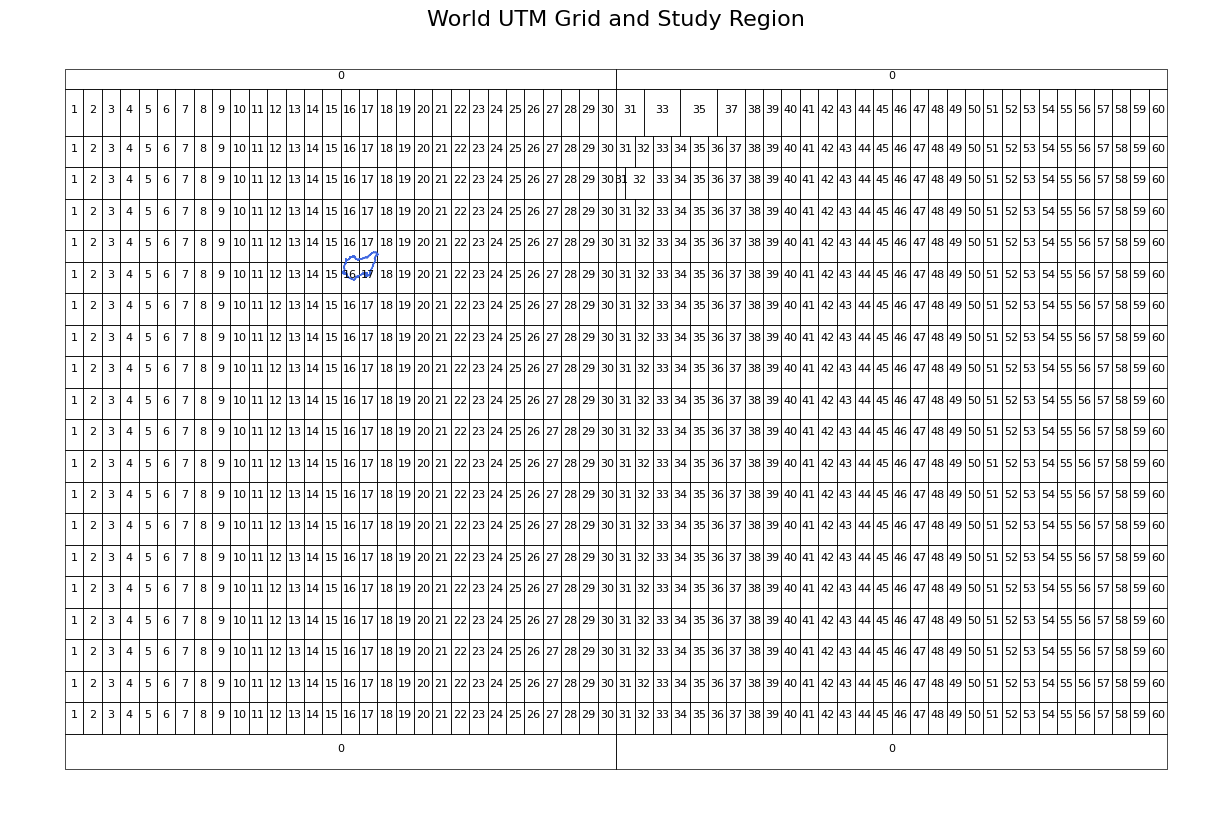

In [44]:
fig, ax = plt.subplots(figsize=(25, 10))
world_utm_grid.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5)
study_area_reprojected.plot(ax=ax, edgecolor='royalblue', facecolor='none', linewidth=1)

# Add UTM zone numbers
world_utm_grid.apply(lambda row: ax.annotate(text=str(row['ZONE']),
                                             xy=row['geometry'].centroid.coords[0],
                                             ha='center', fontsize=8),
                                             axis=1)

ax.set_title('World UTM Grid and Study Region', fontsize=16)
plt.axis('off')
plt.show()

In [34]:
# Filter UTM bounds to be within the bounds of the study area
study_area_bounds = list(study_area.total_bounds)

utm_bounds = world_utm_grid.bounds

utm_intersecting_bounds = (
    (utm_bounds['minx'] < study_area_bounds[2]) &  # UTM left < Basin right
    (utm_bounds['maxx'] > study_area_bounds[0]) &  # UTM right > Basin left
    (utm_bounds['miny'] < study_area_bounds[3]) &  # UTM bottom < Basin top
    (utm_bounds['maxy'] > study_area_bounds[1])    # UTM top > Basin bottom
)
world_utm_zones_filtered = world_utm_grid[utm_intersecting_bounds]
world_utm_zones_filtered

,FID,ZONE,ROW_,WEST_VALUE,CM_VALUE,EAST_VALUE,geometry
509,510,16,T,90W,87W,84W,"POLYGON ((-90 48, -89 48, -88 48, -87 48, -86 ..."
514,515,17,T,84W,81W,78W,"POLYGON ((-84 48, -83 48, -82 48, -81 48, -80 ..."
519,520,18,T,78W,75W,72W,"POLYGON ((-78 48, -77 48, -76 48, -75 48, -74 ..."
805,806,16,S,90W,87W,84W,"POLYGON ((-90 40, -89 40, -88 40, -87 40, -86 ..."
808,809,17,S,84W,81W,78W,"POLYGON ((-84 40, -83 40, -82 40, -81 40, -80 ..."
811,812,18,S,78W,75W,72W,"POLYGON ((-78 40, -77 40, -76 40, -75 40, -74 ..."


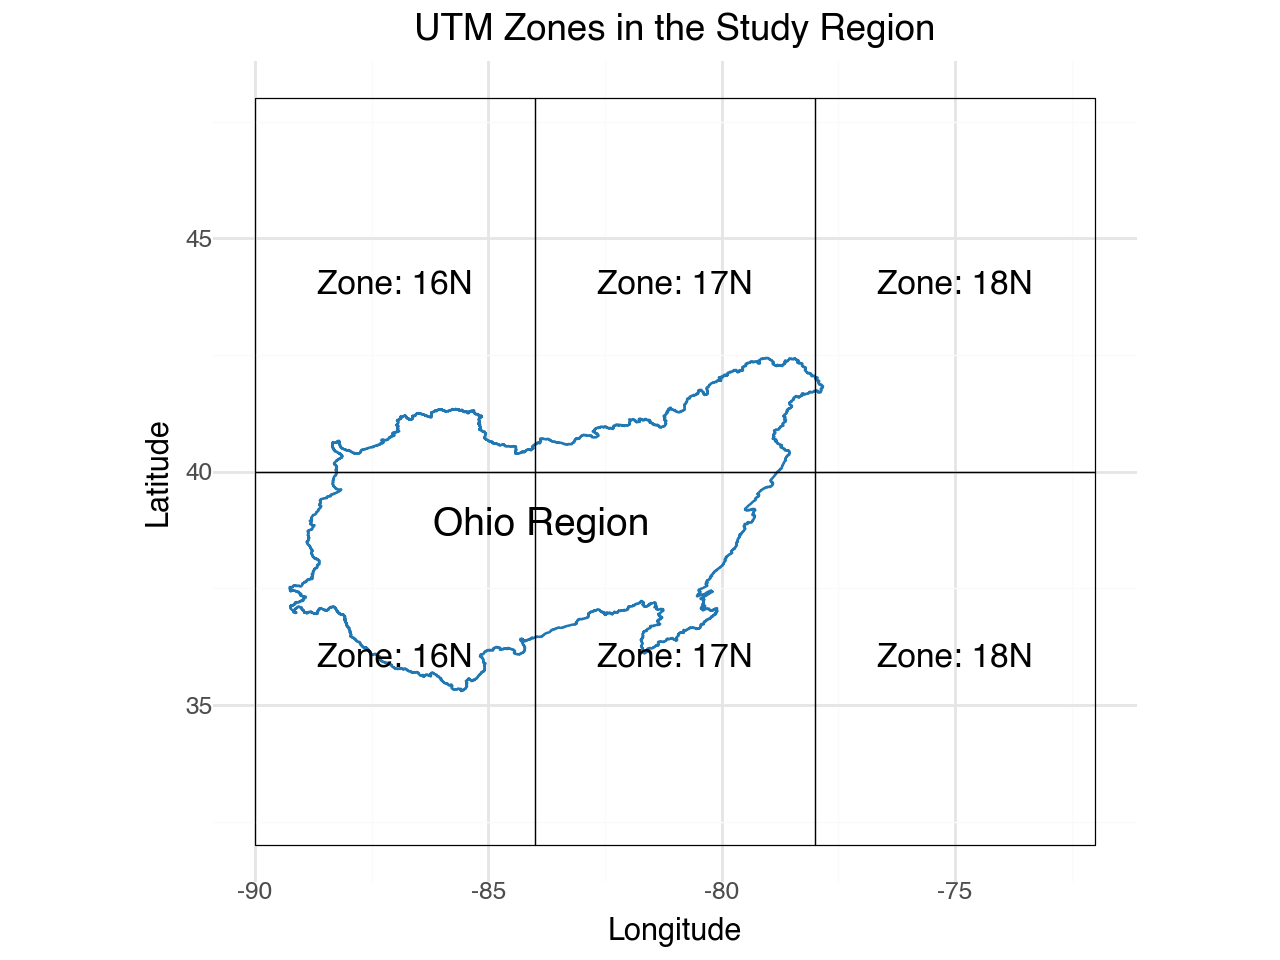

In [54]:
# Define centroid for text legend
world_utm_zones_filtered['lon'] = world_utm_zones_filtered.centroid.x
world_utm_zones_filtered['lat'] = world_utm_zones_filtered.centroid.y

world_utm_zones_filtered['ZONE_str'] = 'Zone: ' + world_utm_zones_filtered['ZONE'].astype(str)+'N'

# Map
utm_zones_map = (
    ggplot(study_area_reprojected)
        + geom_map(
            mapping=aes(geometry="geometry"),
            inherit_aes=True, 
            color = map_style.get('watershed_boundary').get('color'),
            fill=None
        )
         + geom_text(
            mapping=aes(x=study_area_reprojected.centroid.x, y=study_area_reprojected.centroid.y, label="name"),
            size=14,
            color="black"
        )
        + geom_map(
            mapping=aes(geometry="geometry"),
            data=world_utm_zones_filtered,
            inherit_aes=False,
            color="black",
            size=0.25,
            fill = None
        )
        + geom_text(
            mapping=aes(x="lon", y="lat", label="ZONE_str"),
            size=12,
            color="black",
            data = world_utm_zones_filtered,
            inherit_aes=False
        )
        + coord_fixed()
        + theme_minimal()
        + theme(legend_position="none", panel_grid_major=None, panel_grid_minor=None)
        + labs(title="UTM Zones in the Study Region", x="Longitude", y="Latitude")
    
)
utm_zones_map
                 